Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from time import time
import matplotlib.pyplot as plt

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

#print(dataset.shape)

def reformat(dataset, labels):  
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 1001
t_global = time()
t0 = time()

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 200 == 0):
      print("#########################################")
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
      print("Time taken: %0.3fs"%(time()-t0))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  print("Total time taken: %0.3fs"%(time()-t_global))

Initialized
#########################################
Minibatch loss at step 0: 3.032484
Minibatch accuracy: 12.5%
Validation accuracy: 11.6%
Time taken: 3.364s
#########################################
Minibatch loss at step 200: 0.919690
Minibatch accuracy: 68.8%
Validation accuracy: 76.8%
Time taken: 8.103s
#########################################
Minibatch loss at step 400: 0.306710
Minibatch accuracy: 93.8%
Validation accuracy: 79.6%
Time taken: 12.426s
#########################################
Minibatch loss at step 600: 0.371758
Minibatch accuracy: 87.5%
Validation accuracy: 81.3%
Time taken: 17.050s
#########################################
Minibatch loss at step 800: 0.517505
Minibatch accuracy: 81.2%
Validation accuracy: 82.0%
Time taken: 21.064s
#########################################
Minibatch loss at step 1000: 0.437890
Minibatch accuracy: 87.5%
Validation accuracy: 82.5%
Time taken: 24.637s
Test accuracy: 89.6%
Total time taken: 27.144s


---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [7]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    max_conv = tf.nn.max_pool(data,[1,2,2,1],[1,2,2,1],padding = 'SAME')
    conv = tf.nn.conv2d(max_conv, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    max_conv = tf.nn.max_pool(hidden,[1,2,2,1],[1,2,2,1],padding = 'SAME')
    conv = tf.nn.conv2d(max_conv, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [8]:
num_steps = 1001
t_global = time()
t0 = time()

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 200 == 0):
      print("#########################################")
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
      print("Time taken: %0.3fs"%(time()-t0))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  print("Total time taken: %0.3fs"%(time()-t_global))

Initialized
#########################################
Minibatch loss at step 0: 4.146966
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Time taken: 3.672s
#########################################
Minibatch loss at step 200: 0.768309
Minibatch accuracy: 81.2%
Validation accuracy: 77.6%
Time taken: 8.668s
#########################################
Minibatch loss at step 400: 0.271653
Minibatch accuracy: 100.0%
Validation accuracy: 80.5%
Time taken: 13.443s
#########################################
Minibatch loss at step 600: 0.332154
Minibatch accuracy: 87.5%
Validation accuracy: 81.7%
Time taken: 17.485s
#########################################
Minibatch loss at step 800: 0.674514
Minibatch accuracy: 68.8%
Validation accuracy: 82.3%
Time taken: 21.583s
#########################################
Minibatch loss at step 1000: 0.429071
Minibatch accuracy: 87.5%
Validation accuracy: 83.0%
Time taken: 25.527s
Test accuracy: 90.4%
Total time taken: 27.933s


---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [46]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  #paramaters
  weight_regul = tf.placeholder(tf.float32)
  keep_prob = tf.placeholder(tf.float32)
    
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data,prob):
    max_conv = tf.nn.max_pool(data,[1,2,2,1],[1,2,2,1],padding = 'SAME')
    conv = tf.nn.conv2d(max_conv, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    dropout = tf.nn.dropout(hidden,prob)
    
    max_conv = tf.nn.max_pool(dropout,[1,2,2,1],[1,2,2,1],padding = 'SAME')
    conv = tf.nn.conv2d(max_conv, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    dropout = tf.nn.dropout(hidden,prob)
    
    shape = dropout.get_shape().as_list()
    reshape = tf.reshape(dropout, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset,keep_prob)
  l2_weights = tf.nn.l2_loss(layer1_weights)+(
    tf.nn.l2_loss(layer2_weights)+tf.nn.l2_loss(layer3_weights)
      +tf.nn.l2_loss(layer4_weights))
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) +(
      weight_regul*l2_weights)
    
  # Optimizer.
  global_step=tf.Variable(0)
  learning_rate = tf.train.exponential_decay(0.05,global_step,1000,0.65)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset,1))
  test_prediction = tf.nn.softmax(model(tf_test_dataset,1))

In [53]:
def train_model(input_regul,input_dropout):
  num_steps = 3001
  t_global = time()
  t0 = time()

  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                   weight_regul:input_regul, keep_prob:input_dropout}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (step % 1000 == 0):
        print("#########################################")
        print('Minibatch loss at step %d: %f' % (step, l))
        print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
        print('Validation accuracy: %.1f%%' % accuracy(
          valid_prediction.eval(), valid_labels))
        print("Time taken: %0.3fs"%(time()-t0))
        t0 = time()
    test_acc = accuracy(test_prediction.eval(), test_labels)
    print('Test accuracy: %.1f%%' % test_acc)
    print("Total time taken: %0.3fs"%(time()-t_global))
    return test_acc

t_run= time()
print(train_model(0.0005,0.85))


#results = []
#for i in range(0,5):
#    input_prob = round(0.825+0.025*i,6)
#    test_acc = round(train_model(0.0005,input_prob),6)
#    results.append((input_prob,test_acc))
#for i in range(0,5):
#    print("prob: ",results[i][0],"acc: ",results[i][1])
#print("runtime: %0.3fs"%(time()-t_run))

Initialized
#########################################
Minibatch loss at step 0: 3.500395
Minibatch accuracy: 6.2%
Validation accuracy: 9.1%
Time taken: 3.042s
#########################################
Minibatch loss at step 1000: 0.455299
Minibatch accuracy: 87.5%
Validation accuracy: 83.0%
Time taken: 15.446s
#########################################
Minibatch loss at step 2000: 0.158619
Minibatch accuracy: 100.0%
Validation accuracy: 85.1%
Time taken: 15.148s
#########################################
Minibatch loss at step 3000: 0.785220
Minibatch accuracy: 87.5%
Validation accuracy: 85.6%
Time taken: 15.055s
Test accuracy: 92.4%
Total time taken: 51.090s
92.44


92.44% is not very good
should try and repeat for other hyper paramaters, such as
- learning decay
- model width
- model depth
- batch size and patch size
- weight initialisation
- max pooling vs longer strides
- look at leNet


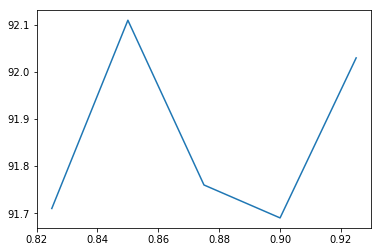

In [52]:
results = np.array(results)
#print(results[:,0])
plt.plot(results[:,0],results[:,1])

muchh of a muchness, probably should just get rid of dropout but will use at 0.85. The problem may be having bouth l2 regularisation and dropout.

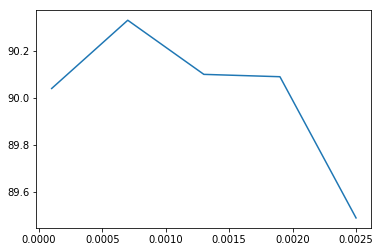

In [42]:
results = np.array(results)
#print(results[:,0])
plt.plot(results[:,0],results[:,1])

used to select l2 weight of 0.0005